# Using synthetic data to better identify the most valuable insurance clients

Customer lifetime value (CLV) is a metric that indicates the total revenue a business can reasonably expect from a single customer account throughout the business relationship. The longer the lifecycle or the more value a customer brings during that lifecycle, the more revenue a business earns. Therefore, tracking and improving CLV results in more revenue. So understanding which customers would have the highest CLV is fundamental for your business. 
Unfortunately, expecially when starting out, there is not enough data to identify these type of customers, with YData's Augmentation power, we show how it is possible to harness the value behind little data. <br>
The Dataset can be found at this link: [kaggle](https://www.kaggle.com/datasets/ranja7/vehicle-insurance-customer-data?resource=download). Only a portion of it was used. 
<br><br>
<div align="center"><img align='center' width="650" height="300" src="diagram.png">,</div>
 


### Traditional Techniques Used 
 + **SMOTE:** Synthetic Minority Over-sampling Technique (SMOTE) is the generation of synthetic data between each sample of the minority class and its “k” nearest neighbors. That is, for each one of the samples, its “k” nearest neighbors are located, then between the pairs of points generated by the sample and each of its neighbors, a new synthetic data is generated.
 + **Borderline-SMOTE:** Borderline-SMOTE is a variation of SMOTE. That is, Borderline-SMOTE detects which samples are on the border of the class space and applies the SMOTE technique to these samples.
 + **SVM-SMOTE:** SVM-SMOTE is slightly different from the borderline-smote, determining the borders using support vector machines.
 + **ADASYN:** Adaptive Synthetic (ADASYN) is a technique that is based on SMOTE. ADASYN implements a methodology that detects those samples that are difficult to classify because they are in a low-density area and then applies SMOTE. 

For more info check out this medium article: [article](https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc?gi=1fd544247dd)

## 0 - Imports

In [1]:
%%capture
!pip install imblearn

In [2]:
from pandas import concat, DataFrame, cut
from numpy import array
from numpy.random import seed 

from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.decomposition import IncrementalPCA

from ydata.dataset import Dataset
from ydata.connectors import GCSConnector, LocalConnector
from ydata.utils.formats import read_json
from ydata.connectors.filetype import FileType
from ydata.synthesizers.regular import RegularSynthesizer
from ydata.report.metrics.predictive_models import performance

import matplotlib.pyplot as plt 
from seaborn import scatterplot

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE

/opt/conda/lib/python3.7/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


## 1 - Load Data

In [22]:
gcs_connector = LocalConnector()
data = gcs_connector.read_file('https://storage.googleapis.com/test_output_pipelines/public_data/auto_insurance_data.csv').to_pandas()

First look into data 

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       1500 non-null   object 
 1   State                          1500 non-null   object 
 2   Customer Lifetime Value        1500 non-null   float64
 3   Response                       1500 non-null   object 
 4   Coverage                       1500 non-null   object 
 5   Education                      1500 non-null   object 
 6   Effective To Date              1500 non-null   object 
 7   EmploymentStatus               1500 non-null   object 
 8   Gender                         1500 non-null   object 
 9   Income                         1500 non-null   int64  
 10  Location Code                  1500 non-null   object 
 11  Marital Status                 1500 non-null   object 
 12  Monthly Premium Auto           1500 non-null   i

In [27]:
data.head(5)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,OJ60800,Oregon,7930.602564,No,Basic,Bachelor,1/27/11,Employed,M,75988,...,40,0,2,Personal Auto,Personal L1,Offer1,Agent,200.545310,Four-Door Car,Medsize
1,TX11163,Nevada,7380.570445,No,Basic,Bachelor,1/21/11,Employed,F,53957,...,80,0,1,Corporate Auto,Corporate L3,Offer1,Branch,61.554272,Luxury SUV,Medsize
2,KG83280,California,3096.511217,Yes,Extended,College,12/2/2011,Employed,F,21604,...,28,0,1,Personal Auto,Personal L1,Offer1,Branch,379.200000,Four-Door Car,Medsize
3,WX16610,California,5824.767025,No,Basic,Bachelor,2/20/11,Employed,F,38492,...,34,0,3,Personal Auto,Personal L3,Offer2,Branch,207.901654,Four-Door Car,Medsize
4,XR84971,Oregon,23515.853250,No,Extended,Doctor,2/18/11,Employed,F,36537,...,4,0,2,Personal Auto,Personal L1,Offer1,Web,165.309001,Four-Door Car,Medsize


## 2 - Problem Setup

Put all the columns lowercase for a better naming, and set the problem dividing customers in terms of clv.  

In [4]:
x = data.columns.str.lower()
x = x.str.replace(' ', '_')
data.columns = x

In [5]:
label_cus = cut(data.customer_lifetime_value,
                   [0, data.customer_lifetime_value.quantile(0.80), data.customer_lifetime_value.max()],
                   labels=[0, 1], include_lowest=True)

data.customer_lifetime_value = array(label_cus)

## 3 - Preprocessing

+ Drop the ID columns that bring no value.
+ Encode categoricals with an OrdinalEncoder.
+ Univariate Selection of the 10 most useful variables for prediction.

### 3.1 - Columns 

In [6]:
data.drop(['customer', 'effective_to_date'], axis=1, inplace=True)

### 3.2 - Categorical Encoding

In [7]:
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(data)
encoded_data = DataFrame(encoded_data, columns=data.columns)

### 3.3 - Feature Selection 

In [8]:
feat_select = SelectKBest()
temp = feat_select.fit_transform(encoded_data.drop('customer_lifetime_value', axis=1), encoded_data.customer_lifetime_value)
scores = {k: v for v, k in zip(feat_select.scores_, encoded_data.drop('customer_lifetime_value', axis=1).columns)}
scores = sorted(scores.items(), key=lambda x: x[1])
columns_selected = [x for x, y in scores[-10:]]
columns_selected.append('customer_lifetime_value')
preprocessed_data = encoded_data[columns_selected]

### 3.4 - Split Data

Split the data into test and train for model training. 

In [9]:
train_data, test_data = train_test_split(preprocessed_data, test_size=0.2, random_state=5)

## 4 - Classification without Augmentation 

### 4.1 - Train and Predict 

In [10]:
classifier = AdaBoostClassifier(random_state=30)
classifier.fit(train_data.drop('customer_lifetime_value', axis=1), train_data.customer_lifetime_value)
y_pred = classifier.predict(test_data.drop('customer_lifetime_value', axis=1))

### 4.2 - Calculate metrics 

In [11]:
results = DataFrame({'technique': 'no_augmentation',
                     'f1_score': f1_score(test_data.customer_lifetime_value, y_pred),
                    'accuracy': accuracy_score(test_data.customer_lifetime_value, y_pred),
                    'precision': precision_score(test_data.customer_lifetime_value, y_pred),
                    'recall': recall_score(test_data.customer_lifetime_value, y_pred)} ,index=[0])

## 5 - Augment with Traditional Techniques  

### 5.1 - Train and Predict 

Train and predict on traditionally augmented data. The techniques used for the augmentation are SMOTE (with variants) and ADASYN.  

In [12]:
upsampling_techniques = [SMOTE(sampling_strategy={0: 17000, 1: 4000}, random_state = 3), SVMSMOTE(sampling_strategy={0: 17000, 1: 4000}, random_state = 3),
                        BorderlineSMOTE(sampling_strategy={0: 17000, 1: 4000}, random_state = 3), ADASYN(sampling_strategy={0: 17000, 1: 4000}, random_state = 3)]
sampled_data = []

for samp_tech in upsampling_techniques:
    smote_x, smote_y = samp_tech.fit_resample(train_data.drop('customer_lifetime_value', axis=1),
                                              train_data.customer_lifetime_value)
    upsampled_data = smote_x.copy()
    upsampled_data['customer_lifetime_value'] = smote_y
    sampled_data.append(smote_x)

    classifier = AdaBoostClassifier(random_state=30)
    classifier.fit(smote_x, smote_y)
    y_preds = classifier.predict(test_data.drop('customer_lifetime_value', axis=1))

    results = results.append({'technique': samp_tech.__class__.__name__, 
                    'f1_score': f1_score(test_data.customer_lifetime_value, y_preds),
                    'accuracy': accuracy_score(test_data.customer_lifetime_value, y_preds),
                    'precision': precision_score(test_data.customer_lifetime_value, y_preds),
                    'recall': recall_score(test_data.customer_lifetime_value, y_preds)}, ignore_index=True)

## 6 - Augmentation with YData Synthesizer 

### 6.1 Train Synthesizer

In [13]:
try:
    generated_data = LocalConnector().read_file('generated_data.csv').to_pandas()
except:
    synth = RegularSynthesizer()
    synth.fit(Dataset(preprocessed_data))
    generated_data = synth.sample(20000).to_pandas()

### 6.2 Upsample Data 

In [14]:
# We previously trained and generated data, so we are reusing it. 
train_data_augmented = concat([generated_data, train_data])

### 6.3 - Train and Predict 

In [15]:
classifier = AdaBoostClassifier(random_state=30)
classifier.fit(train_data_augmented.drop('customer_lifetime_value', axis=1), train_data_augmented.customer_lifetime_value)
y_preds = classifier.predict(test_data.drop('customer_lifetime_value', axis=1))
results = results.append({'technique': 'YData',
                     'f1_score': f1_score(test_data.customer_lifetime_value, y_preds),
                    'accuracy': accuracy_score(test_data.customer_lifetime_value, y_preds),
                    'precision': precision_score(test_data.customer_lifetime_value, y_preds),
                    'recall': recall_score(test_data.customer_lifetime_value, y_preds)} ,ignore_index=True)

## 7 - Compare Results 

### 7.1 - PCA Visualization

Plot data on 2 Dimension to see the results of the augmentations.

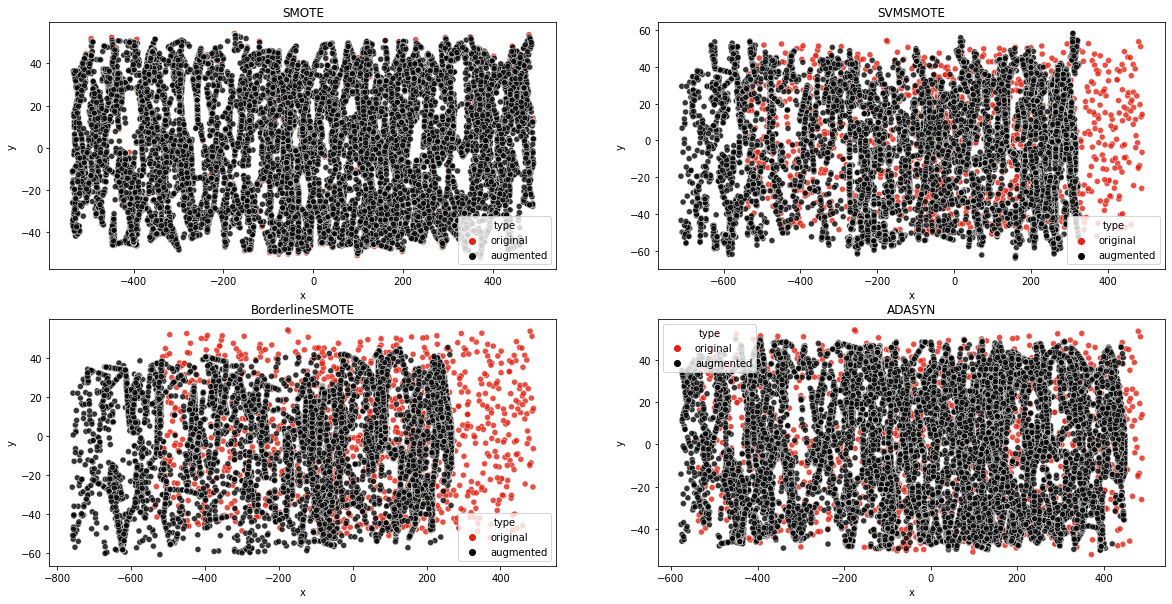

In [16]:
inc_pca = IncrementalPCA(n_components=2)
original = inc_pca.fit_transform(train_data)

fig, axs = plt.subplots(2,2,figsize=[20,10])
df_orig = DataFrame(data=original, columns = ["x", "y"])
df_orig["type"] = "original"

list_tech = results.technique[1:].to_list()
for i, ax in enumerate([axs[0][0], axs[0][1], axs[1][0],axs[1][1]]):
    augmented = inc_pca.fit_transform(sampled_data[i])
    df_augmented = DataFrame(data=augmented, columns=["x", "y"])
    df_augmented["type"] = "augmented"
    df = concat([df_orig, df_augmented], axis=0)
    scatterplot(data=df, hue="type", x="x", y="y", ax=ax, legend="full", alpha=0.8)
    ax.set_title(list_tech[i])

plt.show()



Is possible to see how the generated data through smote techniques it's almost identical to the original one. It is just creating data points that are close to original ones and then filling the gaps in between a point and another. Although it is a good way to augment data that does not differ from the original one, it lacks in terms of variability and fidelity.  

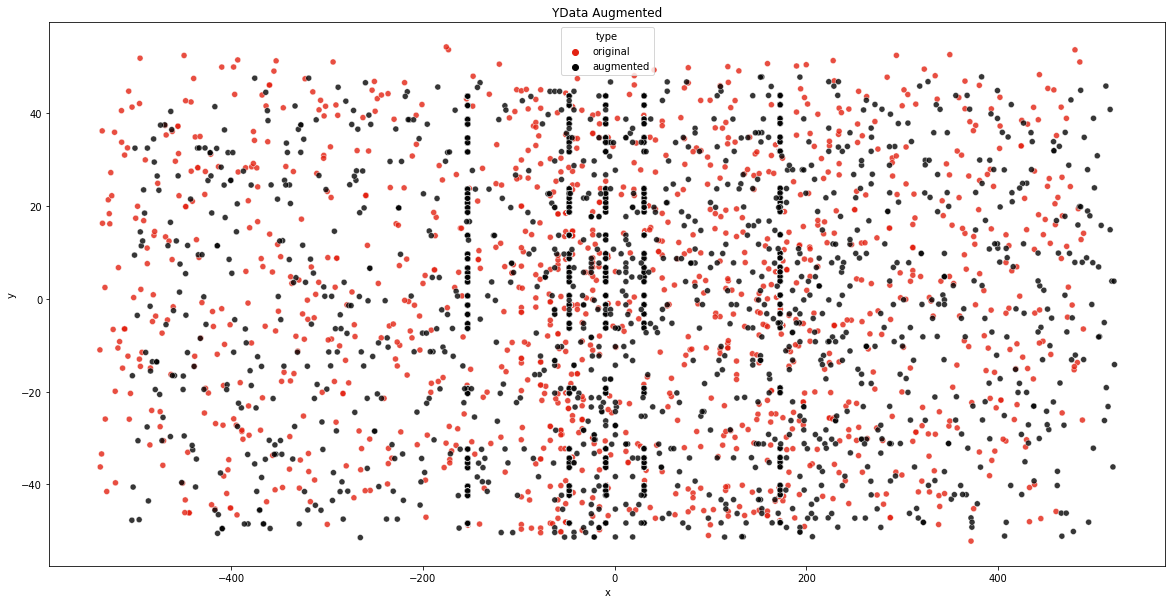

In [17]:
fig1, ax1 = plt.subplots(figsize=[20,10])
ydata_augmented = inc_pca.fit_transform(train_data_augmented)
df_augmented = DataFrame(data=ydata_augmented, columns=["x", "y"])
df_augmented["type"] = "augmented"
df = concat([df_orig, df_augmented], axis=0)
scatterplot(data=df, hue="type", x="x", y="y", ax=ax1, legend="full", alpha=0.8)
ax1.set_title('YData Augmented')
plt.show()

The data generated through YData's Algorithm distributes itself around the projection space in a similar way to the original one, while at the same time adding plausible variability. This behaviours gives a more 'natural' look compared to the traditional methods where the data generated is easier recognizable. 

### 7.2 - Metrics Scores

In [18]:
results

,technique,f1_score,accuracy,precision,recall
0,no_augmentation,0.857143,0.943333,0.836066,0.879310
1,SMOTE,0.805755,0.910000,0.691358,0.965517
2,SVMSMOTE,0.765957,0.890000,0.650602,0.931034
3,BorderlineSMOTE,0.788321,0.903333,0.683544,0.931034
4,ADASYN,0.780142,0.896667,0.662651,0.948276
5,YData,0.870370,0.953333,0.940000,0.810345


From the table is clear that the data generated with our technique is better in many aspects. Both accuracy and f1_score improved. Also, the augmentation brought a huge improval to the precision at classifying the customers. Having an higher precision, leads to a better identification of the valuable customers which carries the business into a better customer retaining management. <br>
YData's augmentation outperfom all the other techniques and improves the classification of high quality customers bringing benefits to the business.  